## <center> PROJET DE DEEP LEARNING  : GROUPE 2


## <center>  GRP8133JK

### Project 2:
Prédiction de la consommation d’énergie (fichier energy.csv)

The data in this file is taken from the GEFCom2014 forecasting competition1. It consists of 3 years of hourly
electricity load and temperature values between 2012 and 2014. The task is to forecast future values of
electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

# One step univariate model

Dans cette partie, nous démontrons comment:
- préparer une donnée de series temporelles avec un model RNN forecasting
- obtenir des données dans la forme requise pour l'API keras
- implémenter un modèle RNN simple en keras pour prédire la prochaine étape (temps * t + 1 *) dans la série temporelle
- permettre un arrêt précoce pour réduire la probabilité de surajustement du modèle
- évaluer le modèle sur un jeu de données de test

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'C:\\Users\\AIMSSN\\Desktop\\PROJET DEEP LEARNING'

#### Importation de la donnée

In [3]:
energy=pd.read_csv('energy.csv',delimiter=",")
energy

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
...,...,...,...
26299,2014-12-31 19:00:00,"4,012.00",18.00
26300,2014-12-31 20:00:00,"3,856.00",16.67
26301,2014-12-31 21:00:00,"3,671.00",17.00
26302,2014-12-31 22:00:00,"3,499.00",15.33


#### Création de l'index de la donnée sous le format DatetimeIndex

In [4]:
index=pd.DatetimeIndex(energy["timestamp"])

In [5]:

energy=energy.iloc[:,1:]


In [6]:
energy

,load,temp
0,"2,698.00",32.00
1,"2,558.00",32.67
2,"2,444.00",30.00
3,"2,402.00",31.00
4,"2,403.00",32.00
...,...,...
26299,"4,012.00",18.00
26300,"3,856.00",16.67
26301,"3,671.00",17.00
26302,"3,499.00",15.33


In [7]:
energy.index=index
energy

,load,temp
timestamp,,
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00


In [8]:
energy.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=26304, freq=None)

## Créaction des données de train, de validation et de test
Nous séparons notre ensemble de données en ensembles de train, de validation et de test. Nous formons le modèle sur le train. Le jeu de validation est utilisé pour évaluer le modèle après chaque période d'apprentissage et s'assurer que le modèle ne surapprend pas les données d'apprentissage. Une fois la formation du modèle terminée, nous évaluons le modèle sur l'ensemble de test. Nous devons nous assurer que l'ensemble de validation et l'ensemble de test couvrent une période ultérieure à partir de l'ensemble d'apprentissage, afin de garantir que le modèle ne tire pas parti des informations des périodes futures.

Nous attribuerons la période du 1er Mai 2014 au 31 décembre 2014 à l'ensemble de test. La période du 1er septembre 2013 au 31 Avril 2014 est allouée à l'ensemble de validation. Toutes les autres périodes sont disponibles pour l'ensemble d'entraînement.

In [9]:
valid_start_dt = '2013-09-01 00:00:00'
test_start_dt = '2014-05-01 00:00:00'

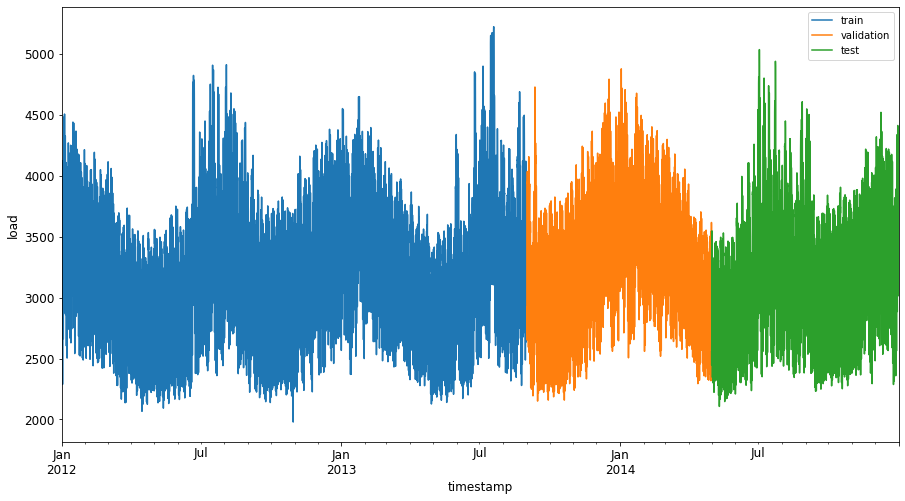

In [10]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

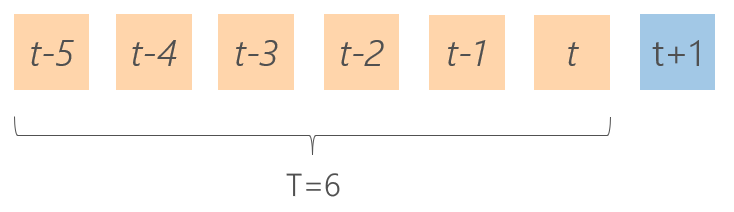

In [39]:
Image('one_step_forecast.png')

In [40]:
T = 6
HORIZON = 1

In [41]:
# 1. Get the train data from the correct data range
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35
...,...,...,...,...,...,...,...,...
2013-08-31 18:00:00,0.60,0.61,0.57,0.57,0.58,0.59,0.60,0.60
2013-08-31 19:00:00,0.61,0.60,0.57,0.58,0.59,0.60,0.60,0.61
2013-08-31 20:00:00,0.60,0.53,0.58,0.59,0.60,0.60,0.61,0.60


In [42]:
y_train=train_shifted[y_col].values
X_train=train_shifted[X_cols].values

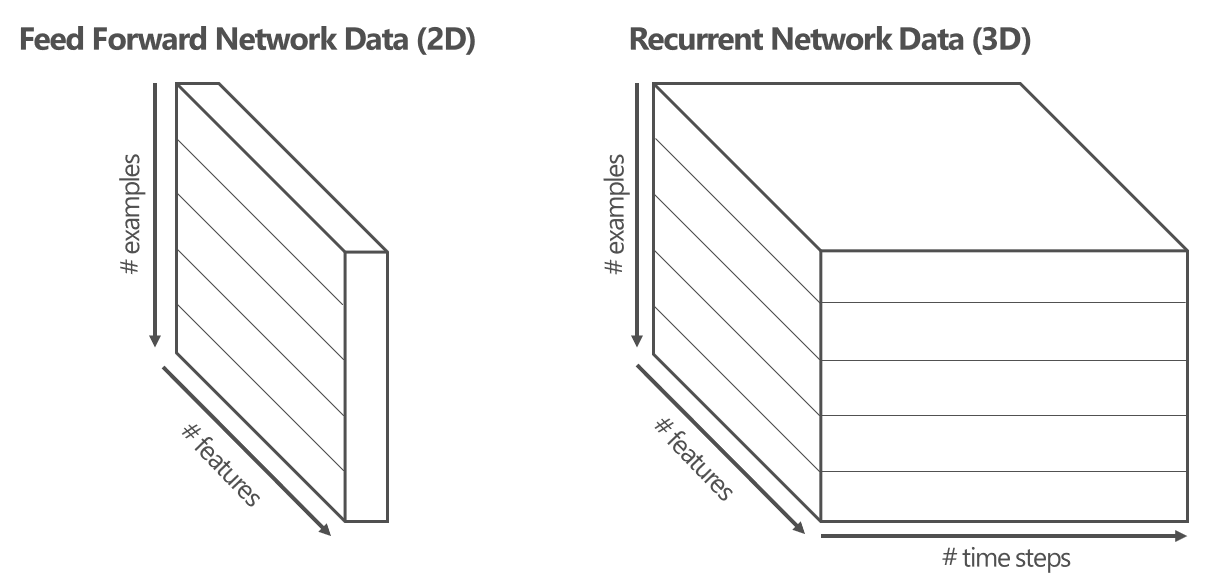

In [43]:
Image('rnn_data_prep.png')

In [44]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [45]:
y_train.shape

(14610,)

In [46]:
y_train[:3]

array([0.18, 0.23, 0.29])

In [47]:
X_train.shape

(14610, 6, 1)

In [48]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [49]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


### Donnée de validation

In [50]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Scale the series using the transformer fitted on the training set:
valid['load'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2013-09-01 00:00:00,0.29,0.25,0.61,0.60,0.53,0.44,0.35,0.29
2013-09-01 01:00:00,0.25,0.23,0.60,0.53,0.44,0.35,0.29,0.25
2013-09-01 02:00:00,0.23,0.21,0.53,0.44,0.35,0.29,0.25,0.23


In [51]:
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [52]:
y_valid.shape

(5807,)

In [53]:
y_valid[:3]

array([0.25, 0.23, 0.21])

In [54]:
X_valid.shape

(5807, 6, 1)

In [55]:
X_valid[:3]

array([[[0.61],
        [0.6 ],
        [0.53],
        [0.44],
        [0.35],
        [0.29]],

       [[0.6 ],
        [0.53],
        [0.44],
        [0.35],
        [0.29],
        [0.25]],

       [[0.53],
        [0.44],
        [0.35],
        [0.29],
        [0.25],
        [0.23]]])

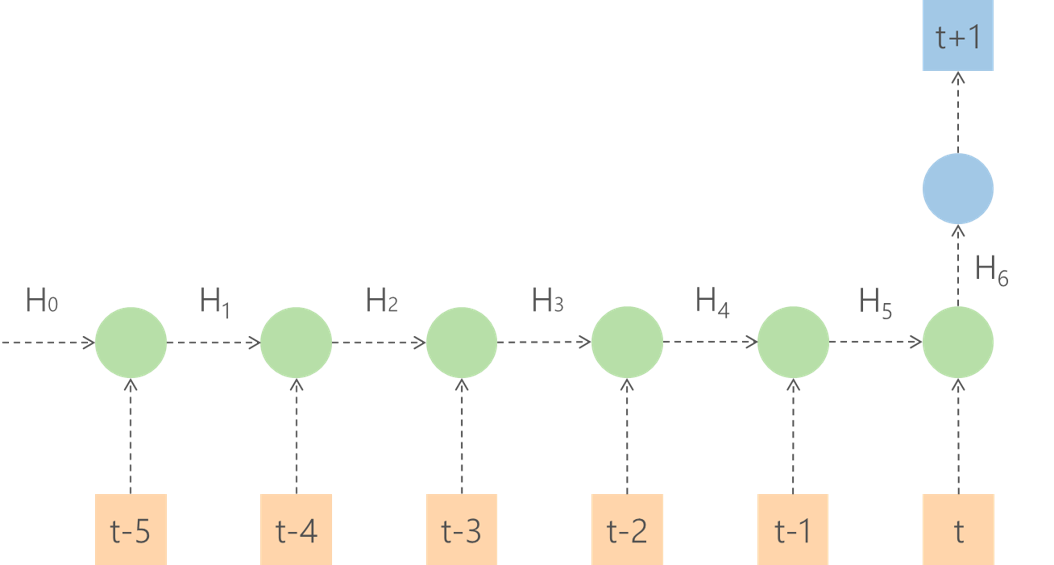

In [56]:
Image('one_step_univariate.png')

In [57]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [58]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [59]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [60]:
model.compile(optimizer='RMSprop', loss='mse')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [62]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [63]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
457/457 [==============================] - 5s 6ms/step - loss: 0.1041 - val_loss: 0.0039
Epoch 2/10
457/457 [==============================] - 1s 3ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/10
457/457 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 8.4127e-04
Epoch 4/10
457/457 [==============================] - 1s 3ms/step - loss: 7.2810e-04 - val_loss: 8.7818e-04
Epoch 5/10
457/457 [==============================] - 1s 3ms/step - loss: 5.8888e-04 - val_loss: 6.7063e-04
Epoch 6/10
457/457 [==============================] - 1s 3ms/step - loss: 5.6981e-04 - val_loss: 8.5945e-04
Epoch 7/10
457/457 [==============================] - 1s 3ms/step - loss: 5.4988e-04 - val_loss: 6.1210e-04
Epoch 8/10
457/457 [==============================] - 1s 3ms/step - loss: 5.5475e-04 - val_loss: 5.8837e-04
Epoch 9/10
457/457 [==============================] - 1s 3ms/step - loss: 5.6711e-04 - val_loss: 5.8650e-04
Epoch 10/10
457/457 [===========================

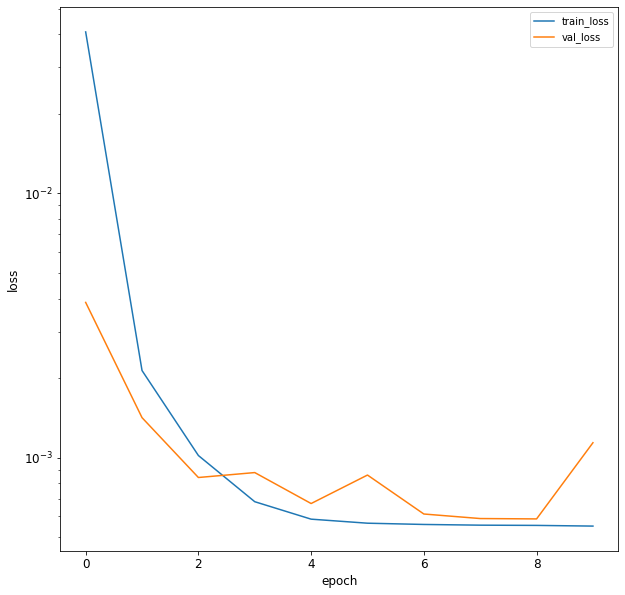

In [64]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [65]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].values
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [66]:
y_test.shape

(5874,)

In [67]:
X_test.shape

(5874, 6, 1)

In [68]:
predictions = model.predict(X_test)
predictions

array([[0.34],
       [0.47],
       [0.46],
       ...,
       [0.51],
       [0.44],
       [0.4 ]], dtype=float32)

In [69]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-05-01 05:00:00,t+1,"3,089.05","3,216.00"
1,2014-05-01 06:00:00,t+1,"3,518.30","3,467.00"
2,2014-05-01 07:00:00,t+1,"3,474.92","3,514.00"
3,2014-05-01 08:00:00,t+1,"3,418.45","3,532.00"
4,2014-05-01 09:00:00,t+1,"3,478.05","3,548.00"


In [70]:
# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [71]:
mape(eval_df['prediction'], eval_df['actual'])

0.024619876403091084

In [72]:
eval_df

,timestamp,h,prediction,actual
0,2014-05-01 05:00:00,t+1,"3,089.05","3,216.00"
1,2014-05-01 06:00:00,t+1,"3,518.30","3,467.00"
2,2014-05-01 07:00:00,t+1,"3,474.92","3,514.00"
3,2014-05-01 08:00:00,t+1,"3,418.45","3,532.00"
4,2014-05-01 09:00:00,t+1,"3,478.05","3,548.00"
...,...,...,...,...
5869,2014-12-31 18:00:00,t+1,"3,900.41","4,012.00"
5870,2014-12-31 19:00:00,t+1,"3,768.50","3,856.00"
5871,2014-12-31 20:00:00,t+1,"3,635.44","3,671.00"
5872,2014-12-31 21:00:00,t+1,"3,410.95","3,499.00"


### Evaluation de la courbe des prédictes et des données réelles sur une période d'une semaine

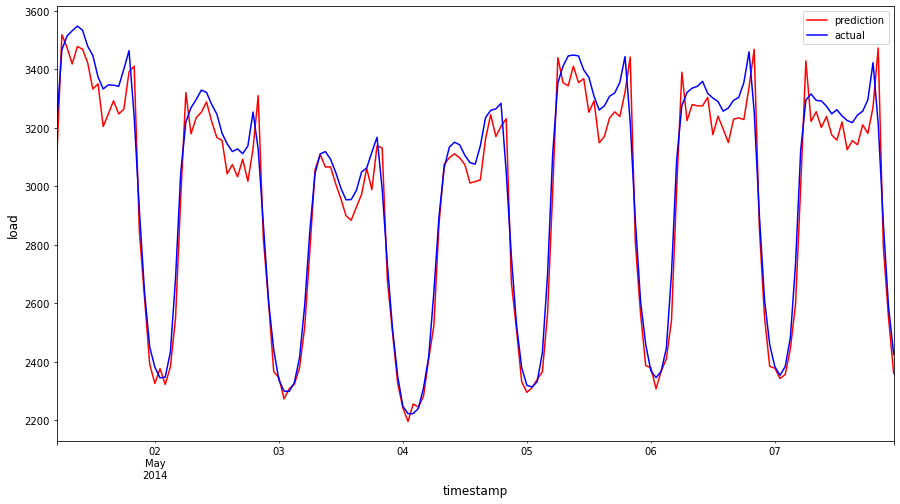

In [73]:
eval_df[eval_df.timestamp<'2014-05-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Dilated CNN model
Dans cette partie, nous démontrons comment:
- préparer une donnée de series temporelles avec un Convolutional Neural Network (CNN) forecasting model
- obtenir des données dans la forme requise pour l'API keras
- implémenter un modèle CNN dans keras pour prédire la prochaine étape (temps * t + 1 *) dans la série temporelle
- permettre un arrêt précoce pour réduire la probabilité de surajustement du modèle
- évaluer le modèle sur un jeu de données de test


In [74]:
from glob import glob

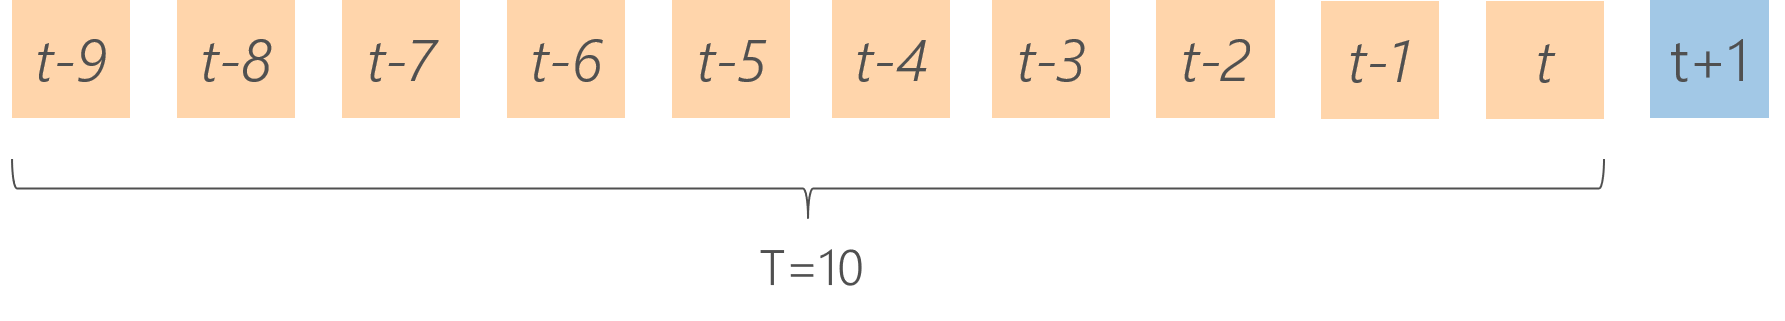

In [77]:
Image('one_step_forecast_T10.png')

In [78]:
T = 10
HORIZON = 1

In [79]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.15
2012-01-01 06:00:00,0.18
2012-01-01 07:00:00,0.23
2012-01-01 08:00:00,0.29


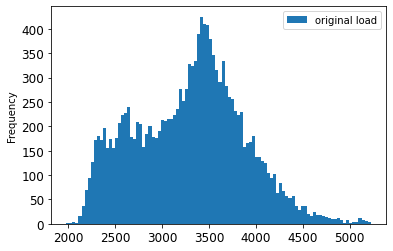

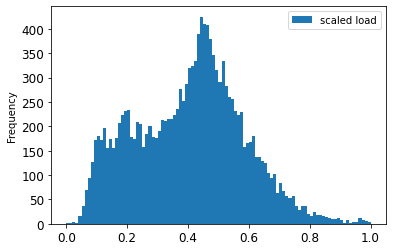

In [81]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

### 3. Décalez les valeurs de la série chronologique pour créer une trame de données Pandas contenant toutes les données d'un seul exemple d'apprentissage
Tout d'abord, nous créons la variable target (* y_t + 1 *). Si nous utilisons la convention selon laquelle la trame de données est indexée à l'heure * t *, nous devons déplacer la variable * load * vers l'avant d'une heure. En utilisant le paramètre freq, nous pouvons dire aux Pandas que la fréquence de la série temporelle est horaire. Cela garantit que le décalage ne saute pas par-dessus les périodes manquantes dans la série temporelle.

In [82]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
timestamp,,
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35


In [83]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,nan,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,nan,nan,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,nan,nan,nan,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,nan,nan,nan,nan,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,nan,nan,nan,0.22,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,nan,nan,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,nan,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29


In [84]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 09:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37,0.37,0.36


In [85]:
y_train = train_shifted[['y_t+1']].values

In [86]:
y_train.shape

(14606, 1)

In [87]:
y_train[:3]

array([[0.37],
       [0.37],
       [0.37]])

In [88]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_train = X_train[... , np.newaxis]

In [89]:
X_train.shape

(14606, 10, 1)

In [90]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37],
        [0.37]]])

In [91]:
train_shifted.head(3)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 09:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37


In [92]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
timestamp,
2013-08-31 15:00:00,"3,855.00"
2013-08-31 16:00:00,"3,885.00"
2013-08-31 17:00:00,"3,928.00"
2013-08-31 18:00:00,"3,942.00"
2013-08-31 19:00:00,"3,974.00"


In [93]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
timestamp,
2013-08-31 15:00:00,0.58
2013-08-31 16:00:00,0.59
2013-08-31 17:00:00,0.60
2013-08-31 18:00:00,0.60
2013-08-31 19:00:00,0.61


In [94]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid[..., np.newaxis]

In [95]:
y_valid.shape

(5807,)

In [96]:
X_valid.shape

(5807, 10, 1)

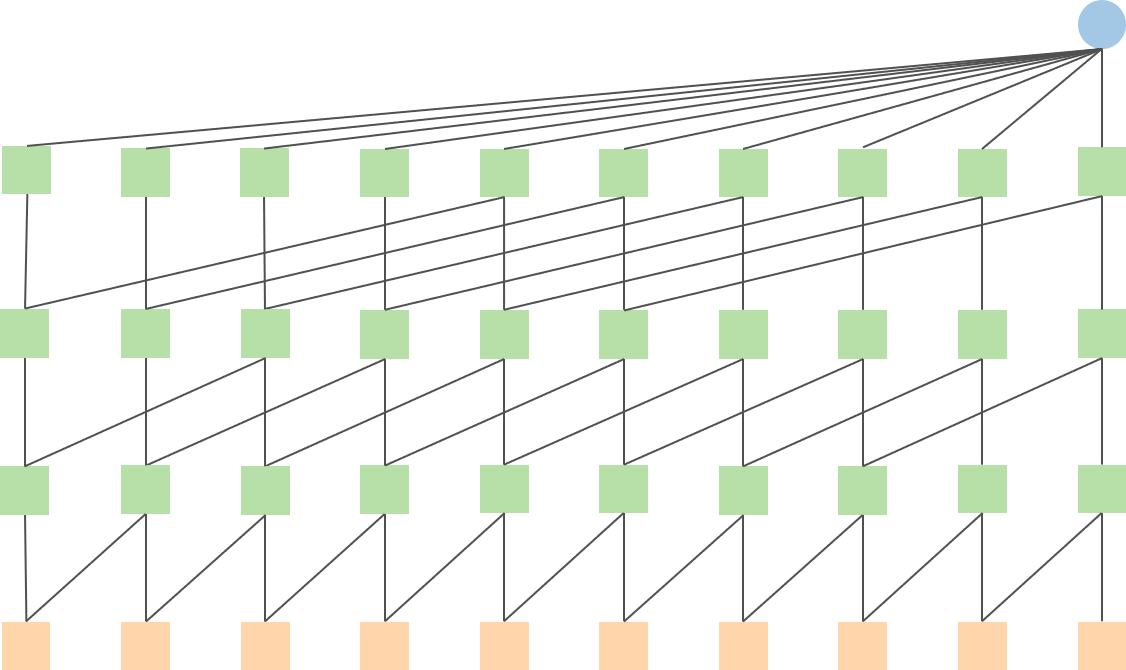

In [98]:
Image('cnn_dilated.png')

In [99]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [100]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [101]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(optimizer='Adam', loss='mse')

In [106]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [107]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [108]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
457/457 [==============================] - 1s 2ms/step - loss: 0.0658 - val_loss: 0.0042
Epoch 2/10
457/457 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 3/10
457/457 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/10
457/457 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
457/457 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 9.9344e-04
Epoch 6/10
457/457 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 8.8813e-04
Epoch 7/10
457/457 [==============================] - 1s 1ms/step - loss: 9.1201e-04 - val_loss: 8.8093e-04
Epoch 8/10
457/457 [==============================] - 1s 1ms/step - loss: 8.4798e-04 - val_loss: 7.7114e-04
Epoch 9/10
457/457 [==============================] - 1s 2ms/step - loss: 7.5950e-04 - val_loss: 6.6948e-04
Epoch 10/10
457/457 [==============================] - 1s 1ms/step -

In [109]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

On trace ici la fonction loss pour les données d'entrainement et de validation

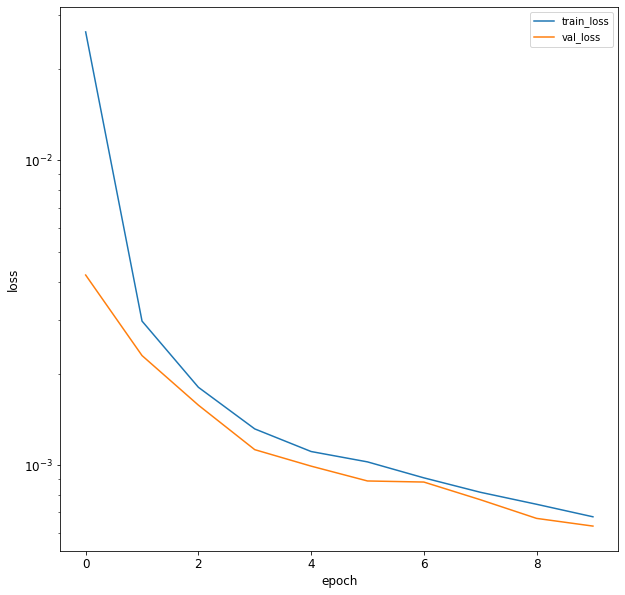

In [110]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

### Evaluation du modèle

In [111]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()


,load
timestamp,
2014-05-01 00:00:00,"2,556.00"
2014-05-01 01:00:00,"2,479.00"
2014-05-01 02:00:00,"2,447.00"
2014-05-01 03:00:00,"2,458.00"
2014-05-01 04:00:00,"2,545.00"


### Centrer la données test

In [112]:
test['load'] = scaler.transform(test)
test.head() 

,load
timestamp,
2014-05-01 00:00:00,0.18
2014-05-01 01:00:00,0.15
2014-05-01 02:00:00,0.14
2014-05-01 03:00:00,0.15
2014-05-01 04:00:00,0.17


### Création des données test

In [113]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].values
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test[... , np.newaxis]

### Prédiction sur le test

In [114]:
predictions = model.predict(X_test)
predictions

array([[0.48],
       [0.49],
       [0.47],
       ...,
       [0.5 ],
       [0.46],
       [0.43]], dtype=float32)

### Comparaison de la prédiction et des données actuelles de 'load'

In [115]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-05-01 09:00:00,t+1,"3,524.05","3,548.00"
1,2014-05-01 10:00:00,t+1,"3,555.81","3,534.00"
2,2014-05-01 11:00:00,t+1,"3,501.12","3,479.00"
3,2014-05-01 12:00:00,t+1,"3,463.99","3,447.00"
4,2014-05-01 13:00:00,t+1,"3,447.73","3,374.00"


### Calcul de l'erreur

In [116]:
mape(eval_df['prediction'], eval_df['actual'])

0.016333591799292543

### Plot  de la prédiction vs les données réelles sur une période d'une semaine

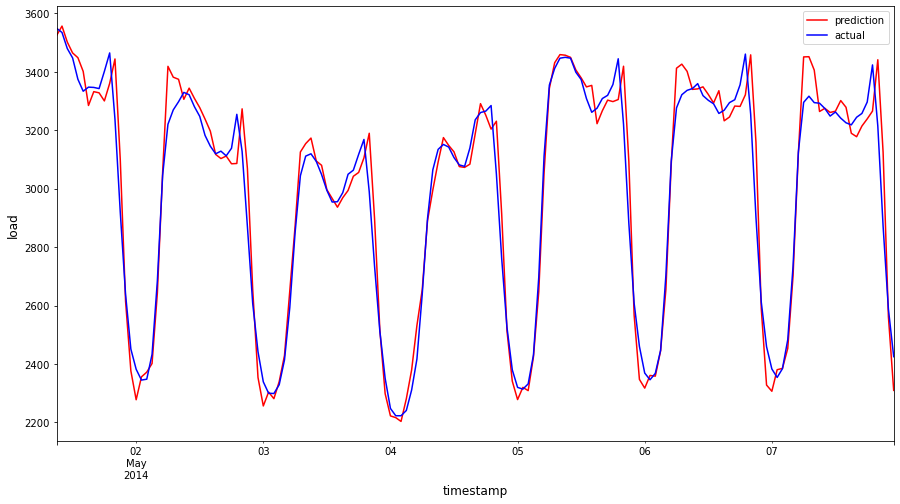

In [117]:
eval_df[eval_df.timestamp<'2014-05-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

### Conclusion

Dans ce notebook on a utilisé deux méthodes pour la prédiction de la données "energy.csv". Après avoir transformer la donnée en série temporelle on a utiliser deux modèles de prédiction: le modèle RNN forecasting, le modèle CNN. Pour évaluer nos modèles nous utilisons l'erreur moyenne en pourcentage (MAPE). Il revient que pour ces deux modèles nous avons des erreurs minimales. La prédiction avec les deux modèles est plus ou moins bonne.